<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Ivan Andres Arellano Ruelas, Jesus Ivan Lafarga Lizarraga

**Fecha:** 13 de octubre del 2021.

**Expediente** : IF708989, IF714383.
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/IvanArellanoRuelas/ProyectoModulo1_ArellanoI_LafargaI

# Proyecto TEMA-2

# Contenido:

1. **Indroducción:** 
    * 1.1 Predicción de nivel de tarjeta de crédito 
    * 1.2 Objetivos
    * 1.3 Definicón del problema 
    * 1.4 Nodos
    * 1.5 Hipotesis y supuestos 
    * 1.6 obtención de bases de datos 

## **1. Introducción:**



### 1.1 Predicción de nivel de tarjeta de crédito
> En base a la información financiera de miles de personas, se determinará que nivel de tarjeta debe recibir esa persona, haciendo que cada una tenga el servicio que espera de una tarjeta de crédito. Esto es de gran utilidad ya que ayuda mucho a la relación que tiene el cliente con el banco, lo que se podría reflejar en que el usuario se mantenga como usuario muchos años, si se le asigna la tarjeta de crédito correcta 

### 1.2 Objetivos: 

> **Objetivo general:**
 * Obtener el nivel correctro de asignación de tarjeta de crédito de un cliente en base a su información financiera 
> **Objetivos especificos**
 * Simular de manera optima nuestros nodos y hacer una comparación contra un grupo de control de 1,000 usuarios reales 
 * Determinar las distribucciones de nuestros nodos 

... "Terminar de pasar todo a este notebook

## 1.6  Obtención de bases de datos

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import scipy.stats as st
import statsmodels.api as sm 
from sklearn.model_selection import GridSearchCV
import warnings 
warnings.filterwarnings("ignore")
db = pd.read_csv('BankChurners.csv',skiprows=2)
db.head(10)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
5,713061558,Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,...,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311
6,810347208,Existing Customer,51,M,4,Unknown,Married,$120K +,Gold,46,...,1,3,34516.0,2264,32252.0,1.975,1330,31,0.722,0.066
7,818906208,Existing Customer,32,M,0,High School,Unknown,$60K - $80K,Silver,27,...,2,2,29081.0,1396,27685.0,2.204,1538,36,0.714,0.048
8,710930508,Existing Customer,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,...,2,0,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113
9,719661558,Existing Customer,48,M,2,Graduate,Single,$80K - $120K,Blue,36,...,3,3,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144


# Funciones en el código: 


In [50]:
# Funciones a utilizar en el proyecto

def kde_sklearn(x, x_grid, bandwidth, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


def generador_vad(proba_acum: 'Probabilidad acumulada', indices: 'Valores por generar', N: 'Aleatorios por generar'):
    diccionario = {i: idx for i, idx in enumerate(indices)}
    U = np.random.rand(N)
    y = pd.Series([sum([1 for p in proba_acum if p < ui]) for ui in U]).map(diccionario)
    return y


def kde_sklearn_mod(x, bandwidth, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    pdf = lambda x_grid: np.exp(kde_skl.score_samples(x_grid[:, np.newaxis])) if isinstance(x_grid, np.ndarray) else \
        np.exp(kde_skl.score_samples(np.array[x_grid])[:, np.newaxis])
    return pdf


def muestreo_est(B: 'Número de estratos'):
    u= np.random.uniform(B) 
    i=np.arange(0,B) 
    v = (u+i)/B 
    return v 



# Función que hace las pruebas para ver una distribución que se ajuste mejor al nodo    
def prueba_dist(nodo: "Nodo", bins: 'bins'):
    '''
    Esta función de devuelve que una gráfica en donde se ve como le quedan distintas distribuciones
    arbitrarias al nodo que el usuario debe ingresar a estudiar, además del orden de menor a menor
    de las distribuciones que se podrán usar más adelante.
    '''
    d_continuas = [d for d in dir(st) if isinstance(getattr(st, d), getattr(st, "rv_continuous"))]

    y, x, _ = plt.hist(nodo, bins=bins, density=True)
    x = x[1:]

    error = pd.DataFrame(columns = ["distribución", "error"])
    i = 0

    for d in d_continuas[10:20]:
        try:
            params = getattr(st, d).fit(nodo)
            y_hat = getattr(st, d)(*params).pdf(x)
            error.loc[i, :] = [d, np.mean(np.abs((y - y_hat)/y))] #Error MAPE
            plt.plot(x, y_hat, label = d)
            i += 1
        except:
            pass
    plt.legend()
    plt.show()

    error.set_index("distribución", inplace=True)
    print(error.sort_values("error"))   
    

# Función que hace la prueba Q_Q y nos muestra la gráfica.    
def q_q(nodo: "Nodo a simular", distr:"Distribución a comparar"):
    '''
    Esta función te arroja como se acomoda la distribución elegida (como entrada),
    del nodo introducido.
    '''
    # Histograma de las variables creadas
    divisiones = 20 # Cantidad de barras en el histograma
    fig, ax = plt.subplots(2,1, figsize=(8,10))
    fig.tight_layout(pad=3.0)

    y, x, _ = ax[0].hist(nodo, divisiones, density=True, label='Histograma mediciones')

    # Función de distribución de probabilidad la cual creemos que mis datos distribuyen 
    # RECORDAR: SÓLO FUNCIONA PARA DISTRIBUCIONES CONTINUAS
    dist = distr
    params = getattr(st, dist).fit(nodo)

    # Graficar PDF de la distribución que queremos probar

    # x = np.arange(measurements.min(), measurements.max(), .01)
    y_hat = getattr(st, dist).pdf(x, *params)
    ax[0].plot(x, y_hat,'r--', label='Distribución ajustada')
    ax[0].set_ylabel('Probability')
    ax[0].grid()

    grap1 = sm.qqplot(nodo, dist=getattr(st, dist), line='q', fit=True, ax=ax[1])
    ax[1].grid()
    ax[1].set_title('Usando paquete stats') 
    
def complementarios_1(N):
    a = np.random.rand(int(N/2))
    b = 1-a
    return np.concatenate((a,b))
    


# Histogramas:

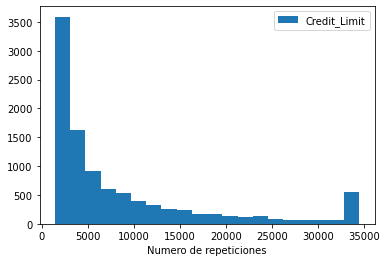

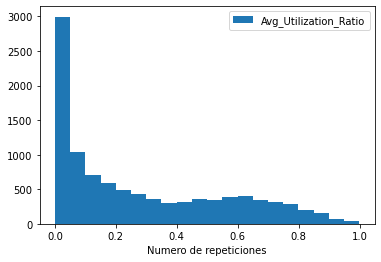

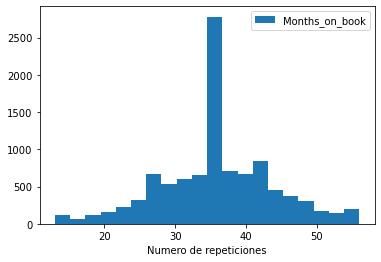

In [8]:
nodos = ['Credit_Limit','Avg_Utilization_Ratio','Months_on_book']
for i in range(3):
    plt.hist(db[nodos[i]], bins=20, label= nodos[i])
    plt.legend()
    plt.xlabel('Numero de repeticiones')
    plt.show()
    

Histograma cuarto nodo: 

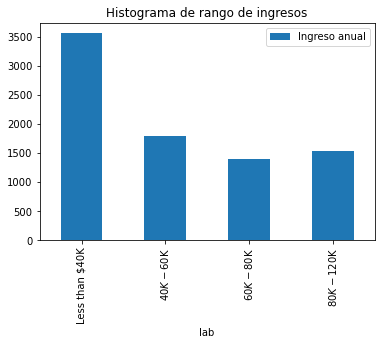

In [12]:
a = sum(db['Income_Category']=='Unknown')
b = sum(db['Income_Category']=='Less than $40K')
c = sum(db['Income_Category']=='$40K - $60K')
d = sum(db['Income_Category']=='$60K - $80K')
e = sum(db['Income_Category']=='$80K - $120K')
df = pd.DataFrame({'lab':['Less than $40K', '$40K - $60K' ,'$60K - $80K','$80K - $120K' ], 
                   'val':[b, c, d, e]})



df.plot.bar(x='lab', y='val',align='center',label = 'Ingreso anual')
plt.title('Histograma de rango de ingresos')
plt.show();

Separamos los datos por cada nodo

# Nodo 1: 
Limite de crédito: 

In [27]:
N_1 = np.array(db.Credit_Limit)

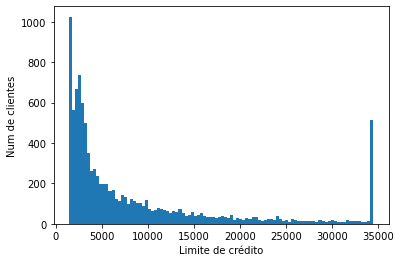

In [47]:
plt.hist(N_1,bins=100)
plt.xlabel('Limite de crédito')
plt.ylabel('Num de clientes')
plt.show()

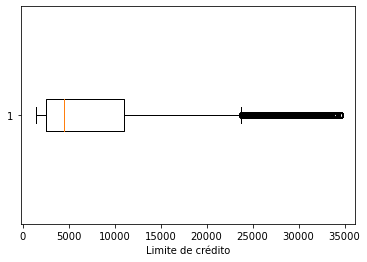

In [48]:
plt.boxplot(N_1, vert=False)
plt.xlabel('Limite de crédito');

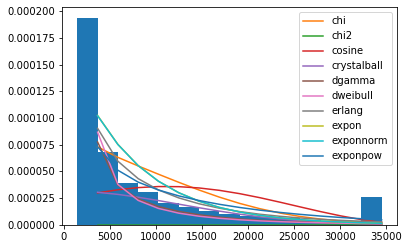

                 error
distribución          
erlang        0.208899
exponnorm     0.332893
expon         0.333547
crystalball   0.371112
exponpow      0.483841
dgamma        0.535668
chi            0.57382
dweibull      0.575099
chi2                 1
cosine         1.08467


In [53]:
prueba_dist(N_1,15)

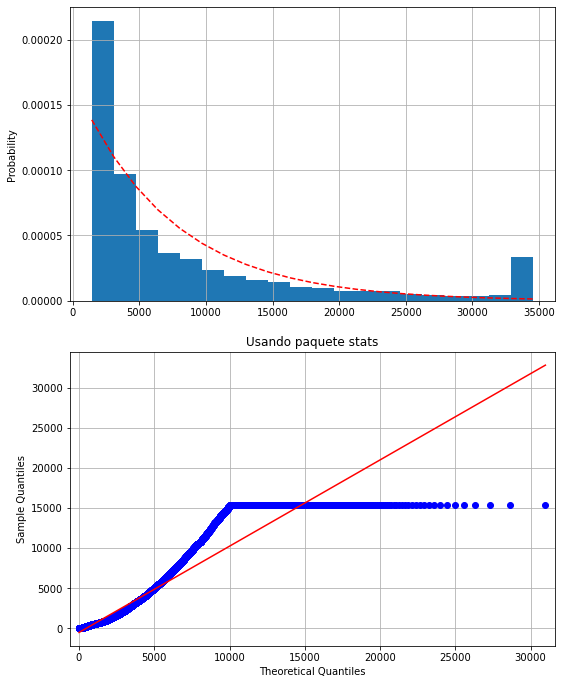

In [54]:
q_q(N_1,'exponnorm')

In [80]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(2, 100, 30)},
                    cv=20) # 20-fold cross-validation
grid.fit(N_1[:, None])
print(grid.best_params_)

{'bandwidth': 15.517241379310345}


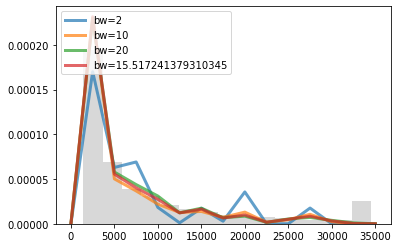

In [81]:
fig, ax = plt.subplots()
for bandwidth in [2,10,20,  15.517241379310345]:
    ax.plot(np.linspace(0,35000,15), kde_sklearn(N_1, np.linspace(0,35000,15), bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(N_1, 15, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')

# Monte carlo 

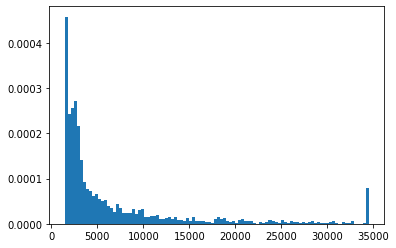

media mu =6580.592740, desviación estándar muestral =7566.391590
8631.953698034955 9088.327899308213


In [96]:

# Reducción de varianza y Montecarlo
N=10000

f_1=kde_sklearn_mod(N_1,  15.517241379310345)
proba = f_1(np.arange(0,35000,.4))
f_acum = proba.cumsum()

# Reducción con método estratificado
u = muestreo_est(N)
funcion2 = lambda u: (generador_vad(f_acum, N_1, N))
o=funcion2(u).values

# Reducción por complementarios

complements=complementarios_1(N)
funcion2_1 = lambda u: (generador_vad(f_acum, N_1, N))
o_2=funcion2(u).values

J = 100  # Cantidad de particiones del histograma

y, x, _ = plt.hist(o, J, density=True)
plt.show()

# Se obvia el último valor de x para obtener exactamente J muestras de x
x = x[:-1] 

# Media y desviación estándar muestral
mu = np.mean(o)
sigma = np.std(o)
print('media mu =%f, desviación estándar muestral =%f'%(mu,sigma))
print(N_1.mean(), N_1.std())

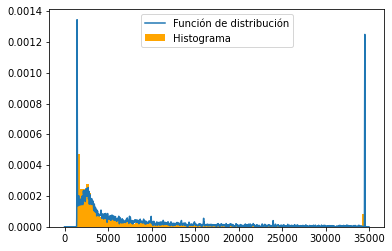

In [84]:

plt.hist(o, bins=100, density = True, color = 'orange',label='Histograma')
plt.plot(np.arange(0,35000,10),f_1(np.arange(0,35000,10)),label='Función de distribución')
plt.legend()
plt.show()

In [85]:
o_2.mean(),o.mean(), N_1.mean()

(6595.51719, 6587.269690000001, 8631.953698034955)

In [90]:
# Otra prueba de hipótesis, con la media simulando a que es 83

media = N_1.mean()
sd = N_1.std()
N = len(N_1)

# Nivel de confianza
confianza = 0.95

# Datos reales
X = N_1

# Hipótesis nula
media2 = 8631

# Realizamos la prueba de hipótesis para H0= mu=media2
ho = st.ttest_1samp(X, media2)
print('La prueba de hipótesis arroja como resultado\n',ho)

# Calculamos el estadístico normalizado
t = (np.mean(X) - media2)/(np.std(X) / np.sqrt(N))
print('Cálculo del estadístico de prueba teórico=', t)

# Cálculo de la región de rechazo
confianza_ph = 0.05
cuantil = st.t(N-1).cdf(1-confianza_ph/2)
print(f'Región de rechazo = (t<{-cuantil}) U (t>{cuantil})')

La prueba de hipótesis arroja como resultado
 Ttest_1sampResult(statistic=0.010559560959662642, pvalue=0.9915750539360884)
Cálculo del estadístico de prueba teórico= 0.010560082355093632
Región de rechazo = (t<-0.8352082246194401) U (t>0.8352082246194401)


In [93]:
# Nivel de confianza, y su intérvalo.

# Parámetros de los datos reales
confianza = .95
media = N_1.mean()
sd = N_1.std()

# Intervalo de confianza usando t-student
i1 = st.t.interval(confianza, len(N_1)-1, loc=np.mean(N_1), scale=st.sem(N_1))

print('Con una confianza de %2.2f la media estará en el intervalo t,\n %s' %(confianza,i1))
print('Media calculada' ,o.mean())

np.mean(N_1)

Con una confianza de 0.95 la media estará en el intervalo t,
 (8454.916294502338, 8808.991101567572)
Media calculada 6587.269690000001


8631.953698034955